# Final Project: Modeling and Controlling Aerobic and Anaerobic Digestion

### Austin Booth, Dominick Cammuso, and Connor Wozniak
Links: https://github.com/ANTIUS88/process-control/blob/main/Model%20Final%20Project%20Final%20Version.ipynb

https://nbviewer.jupyter.org/github/ANTIUS88/process-control/blob/main/Model%20Final%20Project%20Final%20Version.ipynb

This model will predict and control concentrations of biomass, glucose, ethanol, and glycerol over time in an aerobic or anaerobic digestion reactor. Glucose input, ethanol removal, and biomass removal rates are treated as manipulated variables (MVs). Constants and initial conditions are the same as, or adapted from, the dynamic model of Hjersted et al. Digestion is assumed to be occurring in a reactor containing Saccharomyces cerevisiae.

#### Literature Cited:
[1] J.L. Hjersted, M.A. Henson. Steady-state and dynamic flux balance analysis of ethanol production by Saccharomyces cerevisiae. IET Syst. Biol., 3 (2009), pp. 167– 179

[2] H.C. Lange, J.J. Heijnen. Statistical reconciliation of the elemental and molecular biomass composition of Saccharomyces cerevisiae. Biotechnol. Bioeng., 75 (2001), pp. 334-344

# 1. Summary of Variables

X = biomass concentration. Assume this is the measured process variable (PV), a component of the y vector. Units: g/L. X0 = 0.1 g/L.

G = glucose concentration. State variable. Input in biomass production. Units: g/L. G0 = 50 g/L.

E = ethanol concentration. State variable. Product of the reactor. Units: g/L. E0 = 0 g/L. The objective of our control problem is to maintain ethanol around a certain concentration to limit toxicity.

Y = glycerol concentration. State variable. Product of the reactor. Units: g/L. Assume Y0 = 0 g/L. Glycerol concentration will be used as a "catch-all term" to represent all waste/undesired byproducts.

DO = dissolved oxygen concentration. Not directly used in the state space model, but relevant to the linear program and changes the A matrix for the state space model. DO can be regulated by a feedback controller (Hjersted et al.), but for simplification in our case, we will usually assume DO is either 1 (aerobic) or 0 (anaerobic).

DO = O/Osat, where Osat = saturation conc. = 0.30 mmol/L. DO units: fraction saturation (unitless).

# 2. Initial Calculations
Preliminary parameters needed to create the digester model will be calculated here. These parameters will primarily be fluxes, expressed in units of mmol/g/h.

## 2.1. Calculating Glucose and Oxygen Fluxes
The following calculations will require the glucose and oxygen fluxes, or uptake rates, to be known. The allowed glucose flux can be calculated directly as

$$v_g = v_{gm}\frac{G}{K_g + G}\frac{1}{1 + (E / K_{ie})}$$

The allowed oxygen flux can be found by
$$v_o = v_{om}\frac{DO}{DO + (K_o / O_{sat})}$$

Functions for calculating the glucose and oxygen fluxes are given below.

In [8]:
# define known constants
v_gm = 20    # mmol/g/h
K_g = 0.5    # g/L
v_om = 8     # mmol/g/h
K_o = 0.003  # mmol/L
O_sat = 0.30 # mmol/L
K_ie = 10    # g/L
X0 = 0.1     # g/L
G0 = 50      # g/L
E0 = 0       # g/L
Y0 = 0       # g/L

# define function to calculate glucose flux, v_g
def glucose(G, E):
    v_g = v_gm * (G / (K_g + G)) * (1 / (1 + E/K_ie))
    return v_g

# define function to calculate oxygen flux, v_o
def oxygen(DO):
    v_o = v_om * DO / (DO + K_o/O_sat)
    return v_o

# test functions
v_g = glucose(G0,E0)
print('Allowed glucose flux at initial conditions is',round(v_g,3),'mmol/g/h')

v_o = oxygen(1.0)
print('Allowed oxygen flux at maximum DO (aerobic) is',round(v_o,3),'mmol/g/h')
v_o2 = oxygen(0)
print('Allowed oxygen flux in anaerobic conditions is',round(v_o2,3),'mmol/g/h')

Allowed glucose flux at initial conditions is 19.802 mmol/g/h
Allowed oxygen flux at maximum DO (aerobic) is 7.921 mmol/g/h
Allowed oxygen flux in anaerobic conditions is 0.0 mmol/g/h


## 2.2. Simplified Linear Program
In Hjersted et al., the cellular growth rate, or total allowed flux of biomass, is found by a linear program:

\begin{align}
\max {\mu} & = \sum_{j} w_j v_j
\end{align}

where v for each component is its flux and w is its weight, subject to the constraints

$$Av = 0$$ and $$v_{min} < v < v_{max}$$

where A is a stoichiometric matrix of a metabolic network, v is a vector of fluxes, and v_min and v_max are vectors of upper and lower flux bounds.

To simplify, we will assume that glucose and oxygen are the only relevant inputs to biomass production, and for further simplification, we will assume that their weights are both 1. Thus, in this highly simplified model, the cellular growth rate is equal to the allowed uptake rate of oxygen plus the allowed uptake rate of glucose.

In [9]:
# calculate cellular growth rate
mu = v_g + v_o

print('Total allowed cellular growth rate is',round(mu,3),'mmol/g/h')

Total allowed cellular growth rate is 27.723 mmol/g/h


## 2.3. Mass Balance

The remaining fluxes were found in Hjersted et al. by using the matrix and vector constraints mentioned above. However, the stoichiometric matrices of the metabolic networks are extremely involved and not given in any detail in this paper, and they contain many times more variables than we are concerned with here. The maximum and minimum flux constraints are also not discussed at all in this paper. For this reason, we will solve for the ethanol and glycerol fluxes using a mass balance.

According to Lange et al., the molecular weight of S. cerevisiae biomass is 26.4 g/mol. The MW of glycerol is 92.094 g/mol, the MW of ethanol is 46.07 g/mol, the MW of glucose is 180.16 g/mol, and the MW of oxygen is 32.00 g/mol.

Fluxes are expressed relative to total biomass concentration (X), and each species' rate of change is given by its respective flux times X. The units of vX in each case are 
$$\frac{dA}{dt} = v_a*X = \frac{mmol}{g*h}*\frac{g}{L} = \frac{mmol}{L*h} = \frac{mM}{h}$$

To find each species' rate of change in terms of its original mass-based units, we can take

$$\frac{dA_{true}}{dt} = v_a*X*MW_a*\frac{1}{1000} = \frac{mmol}{g*h}*\frac{g}{L}*\frac{g}{mol}*\frac{mol}{mmol}
= \frac{g}{L*h}$$

If we take out the common factor of X/1000 for each component and consider inputs and outputs, the mass balance can be simplified to:

$$v_g MW_g + v_o MW_o - \mu MW_x - v_e MW_e - v_y MW_y = 0$$

We now need additional constraints to find both unknowns, v_e and v_y. As in Hjersted et al., our objective will be to maximize ethanol production, so we will set the objective to maximize ethanol flux with the arbitrary constraint that it must not exceed the total growth rate.

In [108]:
import numpy as np
import cvxpy as cp

# enter molecular weights
MW_x = 26.4    # g/mol
MW_y = 92.094  # g/mol
MW_e = 46.07   # g/mol
MW_g = 180.16  # g/mol
MW_o = 32.00   # g/mol

# make relevant elements negative in data structure
# contains unused H element from earlier v
data = {
    'X': {'MW': -MW_x},
    'Y': {'MW': -MW_y},
    'E': {'MW': -MW_e},
    'G': {'MW': MW_g},
    'O': {'MW': MW_o},
}

# create function that will solve mass balance to maximize ethanol flux
def solve_EG(mu, v_g, v_o, data):
    # create set of components
    components = set(data.keys())
    
    # create variables
    v = {c: cp.Variable(nonneg=True, name=c) for c in components}
    
    # create objective function
    objective = cp.Maximize(v['E'])
    
    # create list of constraints
    constraints = [

        v['X'] == mu,
        v['O'] == v_o,
        v['G'] == v_g,
        v['E'] <= mu,

        0 == sum(v[c]*data[c]['MW'] for c in components),
    ]
    
    # create and solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    # return results
    v_e = problem.value
    optimal_blend = {c: v[c].value for c in components}
    v_e = optimal_blend['E']
    v_y = optimal_blend['Y']
    return v_e, v_y, optimal_blend


# print results for DO = 1 and DO = 0
print('Aerobic digestion with DO = 1 and initial conditions:')
v_e, v_y, optimal_blend = solve_EG(mu,v_g,v_o,data)
print(v_e)
print(v_y)
for c in (optimal_blend.keys()):
    print(f"{c} flux: {optimal_blend[c]:5.2f} mmol/g/h")
    
print()
print('Anaerobic digestion with DO = 0 and initial conditions:')
v_e, v_y, optimal_blend = solve_EG((v_g + v_o2),v_g,v_o2,data)
for c in (optimal_blend.keys()):
    print(f"{c} flux: {optimal_blend[c]:5.2f} mmol/g/h")

Aerobic digestion with DO = 1 and initial conditions:
27.722772276906497
19.674688818967653
G flux: 19.80 mmol/g/h
O flux:  7.92 mmol/g/h
E flux: 27.72 mmol/g/h
Y flux: 19.67 mmol/g/h
X flux: 27.72 mmol/g/h

Anaerobic digestion with DO = 0 and initial conditions:
G flux: 19.80 mmol/g/h
O flux:  0.00 mmol/g/h
E flux: 19.80 mmol/g/h
Y flux: 23.16 mmol/g/h
X flux: 19.80 mmol/g/h


# 3. Nonlinear Model with No Control

Now that we have a way to get fluxes for each component, we can use the series of differential equations from Hjersted et al. to develop a time-dependent model of the reactor. The paper's equations are multiplied by molecular weight and divided by 1000 to get d[A]/dt in units of g/L/h instead of mM/h.

For future use, we will add R, the input rate of glucose, in g/L/h. Later parts of this notebook will add removal rates for ethanol and biomass. Here, R will just be kept as zero or constant, and glucose will be allowed to be depleted.

\begin{align}
\frac{dX}{dt} & = \mu X * MW_x / 1000\\
\frac{dG}{dt} & = -v_g X * MW_g / 1000 + R_{input}(t)\\
\frac{dE}{dt} & = v_e X * MW_e / 1000\\
\frac{dY}{dt} & = v_y X * MW_y / 1000\\
\end{align}

where mu, v_g, v_e, and v_y are all dependent on G, E, and DO. This model will be derived below similarly to in Notebook 2.4.

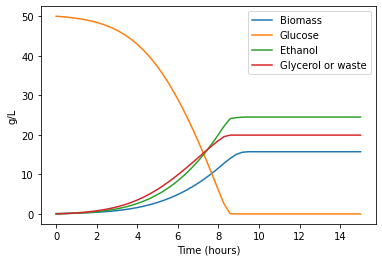

In [109]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# create function to determine value of DO over time
def DO_MV(t):
    DO = 1.0
    return DO

# create function to set glucose addition rate R as an MV
def Radd(t):
    R = 0
    return R

# create time vector
t_expt = np.linspace(0,15,50)

def model_second_order(plot=False):    

    # model solution
    def deriv(t, y):
        # unpack variables
        X, G, E, Y = y
        
        # calculate parameters
        DO = DO_MV(t)
        v_o = oxygen(DO)
        
        # prevent model from failing by stopping growth once glucose is depleted
        if G - Radd(t) > 0:
            v_g = glucose(G, E)
            mu = v_o + v_g
        else:
            v_g = 0
            mu = 0
            v_o = 0
        
        v_e, v_y, optimal_blend = solve_EG(mu, v_g, v_o, data)
        
        
        dX = mu * X * MW_x / 1000
        dG = -v_g * X * MW_g / 1000 + Radd(t)
        dE = v_e * X * MW_e / 1000
        dY = v_y * X * MW_y / 1000

        return [dX, dG, dE, dY]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [X0, G0, E0, Y0], t_eval=t_expt) 
    
    # create vectors with predictions
    Xpred = soln.y[0]
    Gpred = soln.y[1]
    Epred = soln.y[2]
    Ypred = soln.y[3]


    # plot solution
    if plot:
        plt.plot(t_expt, Xpred, t_expt, Gpred, t_expt, Epred, t_expt, Ypred)
        plt.xlabel('Time (hours)')
        plt.ylabel('g/L')
        plt.legend(['Biomass','Glucose','Ethanol','Glycerol or waste'])
    
model_second_order(plot=True)

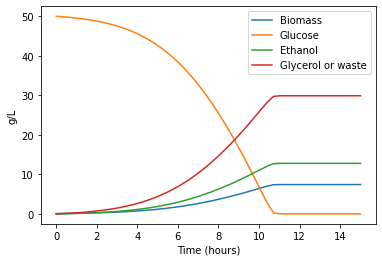

In [110]:
# with DO = 0
def DO_MV(t):
    DO = 0
    return DO
model_second_order(plot=True)

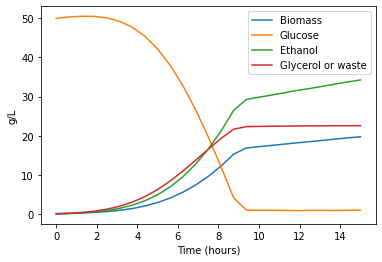

In [111]:
# create time vector
t_expt = np.linspace(0,15,25)

# with DO = 1 and a glucose addition rate of 1 g/L/h
def DO_MV(t):
    DO = 1.0
    return DO

def Radd(t):
    R = 1
    return R

model_second_order(plot=True)

# 4. Linear State-Space Model

## 4.1. Derivation
A linear state-space model can be constructed by simplifying some complications of the nonlinearly concentration-dependent expressions for fluxes.

For aerobic digestion, assuming DO >> 0.01, we can approximate $$v_o = v_{om}$$
For anaerobic digestion, $$v_o = 0$$

Notably, this result is suitable for relay control; i.e., on-off switching between aerobic and anaerobic conditions. If we assume that DO control is relay (1 or 0), we can say that $$v_o = v_{om}*DO$$

though this result is not very useful for the state space model since it will introduce higher-order dependence.

Also, if we assume G >> Kg and E << K_ie for the entire reaction, we can approximate 
$$v_g = v_{gm}\frac{G}{G}\frac{1}{1} = v_{gm}$$

Next, we are treating the maximum allowed growth rate as the sum of oxygen and glucose flux, so (under aerobic digestion)
$$\mu = v_{gm} + v_{om}$$

To simplify the optimization problem's constraints, we can set the growth rate equal to the ethanol flux, so
$$v_e = v_{gm} + v_{om}$$

Finally, by solving the mass balance,
$$v_y = \frac{v_{gm}*MW_g + v_{om}*MW_o - (v_{gm} + v_{om})*(MW_x + MW_e)}{MW_y}$$


## 4.2. Differential Equation Format

Under anaerobic digestion, any v_om terms can be set to 0.

Here, we will reformat the vector of MVs (u) to include rates of glucose input (Rg), ethanol removal (Re), and biomass removal (Rx).

\begin{align}
\frac{dX}{dt} & = (v_{gm} + v_{om}) X * MW_x / 1000 - R_x(t)\\
\frac{dG}{dt} & = -v_{gm} X * MW_g / 1000 + R_g(t)\\
\frac{dE}{dt} & = (v_{gm} + v_{om}) X * MW_e / 1000 - R_e(t)\\
\frac{dY}{dt} & = \frac{v_{gm}MW_g + v_{om}MW_o - (v_{gm} + v_{om})(MW_x + MW_e)}{MW_y} X * MW_y / 1000\\
\end{align}

## 4.3. State Space Format

It is assumed that the biomass concentration in the reactor is the only measurable process variable. Disturbance variables and the disturbance vector will not be considered.


\begin{align}
\frac{d}{dt}\underbrace{\left[\begin{array}{c} X \\ G \\ E \\ Y \end{array}\right]}_x
& = 
\underbrace{\left[\begin{array}{cccc}
\frac{(v_{gm} + v_{om})MW_x}{1000} & 0 & 0 & 0 \\
-\frac{v_{gm}MW_g}{1000} & 0 & 0 & 0 \\
\frac{(v_{gm} + v_{om})MW_e}{1000} & 0 & 0 & 0 \\
\frac{v_{gm}MW_g + v_{om}MW_o - (v_{gm} + v_{om})(MW_x + MW_e)}{1000} & 0 & 0 & 0
\end{array}\right]}_A
\underbrace{\left[\begin{array}{c}X \\ G \\ E \\ Y\end{array}\right]}_x
+
\end{align}

\begin{align}
\underbrace{\left[\begin{array}{cc}0 & 0 & -1 \\ 1 & 0 & 0 \\ 0 & -1 & 0 \\ 0 & 0 & 0 \end{array}\right]}_{B_u}
\underbrace{\left[\begin{array}{c}R_g \\ R_e \\ R_x \end{array}\right]}_u
+
\underbrace{\left[\begin{array}{c}0 \\ 0 \\ 0 \\ 0 \end{array}\right]}_{B_d}
\underbrace{\left[\begin{array}{c}0\end{array}\right]}_{d}
\end{align}

\begin{align}
\underbrace{\left[\begin{array}{c} X_{meas} \end{array}\right]}_y
& = 
\underbrace{\left[\begin{array}{cccc} 1 & 0 & 0 & 0 \end{array}\right]}_C
\underbrace{\left[\begin{array}{c}X \\ G \\ E \\ Y\end{array}\right]}_x
\end{align}

## 4.4. Approximate State Space Model Construction

This model will be constructed in the code below.

In [141]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# define known constants
v_gm = 20    # mmol/g/h
K_g = 0.5    # g/L
v_om = 8     # mmol/g/h
K_o = 0.003  # mmol/L
O_sat = 0.30 # mmol/L
K_ie = 10    # g/L
X0 = 0.1     # g/L
G0 = 50      # g/L
E0 = 0       # g/L
Y0 = 0       # g/L
MW_x = 26.4    # g/mol
MW_y = 92.094  # g/mol
MW_e = 46.07   # g/mol
MW_g = 180.16  # g/mol
MW_o = 32.00   # g/mol


A = np.array([[(v_gm + v_om)*MW_x / 1000, 0, 0, 0], 
              [-v_gm*MW_g/1000, 0, 0, 0],
              [(v_gm + v_om)*MW_e / 1000, 0, 0, 0],
              [(v_gm*MW_g + v_om*MW_o - (v_gm + v_om)*(MW_x + MW_e))/1000, 0, 0, 0]])

# insert biomass removal term
Bu = np.array([[0, 0, -1], [1, 0, 0], [0, -1, 0], [0, 0, 0]])

C = np.array([[1, 0, 0, 0]])

# initial values for states and inputs
u_initial = np.array([0, 0 , 0])
x_initial = np.array([X0, G0, E0, Y0])

print('A:')
print(A)
print('Bu:')
print(Bu)
print('C:')
print(C)

A:
[[ 0.7392   0.       0.       0.     ]
 [-3.6032   0.       0.       0.     ]
 [ 1.28996  0.       0.       0.     ]
 [ 1.83004  0.       0.       0.     ]]
Bu:
[[ 0  0 -1]
 [ 1  0  0]
 [ 0 -1  0]
 [ 0  0  0]]
C:
[[1 0 0 0]]


In [142]:
# define different A if process is anaerobic and all oxygen flux is 0:
A_anaerobic = np.array([[(v_gm)*MW_x / 1000, 0, 0, 0], 
              [-v_gm*MW_g/1000, 0, 0, 0],
              [(v_gm)*MW_e / 1000, 0, 0, 0],
              [(v_gm*MW_g - (v_gm)*(MW_x + MW_e))/1000, 0, 0, 0]])
print('A under anaerobic conditions:')
print(A_anaerobic)

A under anaerobic conditions:
[[ 0.528   0.      0.      0.    ]
 [-3.6032  0.      0.      0.    ]
 [ 0.9214  0.      0.      0.    ]
 [ 2.1538  0.      0.      0.    ]]


# 5. Optimal/Predictive Control

## 5.1. Open-Loop Control with Constraints

Only aerobic conditions are explored here to save space. Now that we have the state-space model, we can perform optimal control to achieve a specific objective. For our objective, we chose to keep ethanol close to a certain arbitrary value. This is a suitable real-world objective if we want to limit toxicity to the biomass in the reactor. This assumes that biomass and ethanol can be removed at variable rates, and glucose can be added at a variable rate.

This controller uses the state space model to program open-loop optimal control with no measured variables. The optimization objective is to keep the ethanol concentration as close to 100 g/L for as much of the time range as possible.

Constraints are as follows to help maintain realistic conditions:
1. Keep glucose level under 100 g/L for the entire time range.
2. Keep biomass level under 200 g/L for the entire time range.
3. Keep biomass removal rate at 0 g/L for the first 5 hours to allow growth of biomass.
4. Keep all component removal and addition rates below 200 g/L for the entire time range.

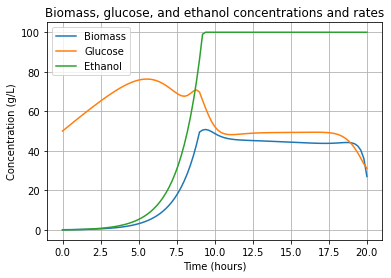

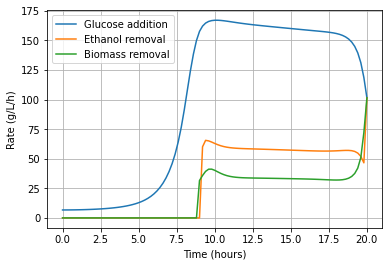

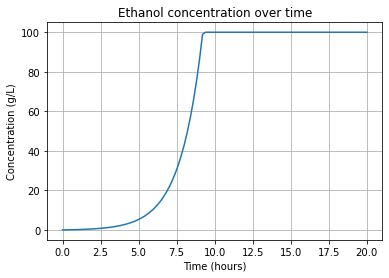

In [144]:
import cvxpy as cp
import numpy as np

t_horizon = 20
dt = 0.2
n = round(t_horizon/dt)
t_grid = np.linspace(0, t_horizon, n+1)

x = {k: cp.Variable(4, nonneg=True) for k,t in enumerate(t_grid)}
u = {k: cp.Variable(3, nonneg=True) for k,t in enumerate(t_grid)}

model = [
    x[k] == x[k-1] + dt*(A@x[k-1] + Bu@u[k-1]) for k,t in list(enumerate(t_grid))[1:]
]

IC = [x[0] == np.array([X0, G0, E0, Y0])]

# objective: keep ethanol around 100 g/L for as long as possible
objective = cp.Minimize(sum(cp.abs(100-x[k][2]) for k,t in list(enumerate(t_grid))))

# constraints section

# constrain glucose level to maximum of 100 g/L for all times
Glevel = [ x[k][1] <= 100 for k,t in list(enumerate(t_grid)) ]

# constrain biomass level to maximum of 200 g/L for all times
Xlevel = [ x[k][0] <= 200 for k,t in list(enumerate(t_grid)) ]

# constrain biomass removal rate to 0 g/L/h for the first 5 hours
Xrate = [ u[k][2] == 0 for k,t in list(enumerate(t_grid))[0:1]  ]

# constrain glucose addition rate to maximum of 200 g/L/h for all time
Grate = [ u[k][0] <= 200 for k,t in list(enumerate(t_grid)) ]

# constrain ethanol removal rate to maximum of 200 g/L/h for all time
Erate = [ u[k][1] <= 200 for k,t in list(enumerate(t_grid)) ]

# constrain biomass removal rate to maximum of 200 g/L/h for all time
Xratemax = [ u[k][2] <= 200 for k,t in list(enumerate(t_grid)) ]

prob = cp.Problem(objective, Glevel + Xlevel + Grate + Xrate + Erate + Xratemax + model + IC)
prob.solve(verbose=False)

# set up plot and assign variables
fig, ax = plt.subplots(1, 1, sharex=True)
fig, ax1 = plt.subplots(1, 1, sharex=True)

X = [x[k][0].value for k,t in enumerate(t_grid)]
G = [x[k][1].value for k,t in enumerate(t_grid)]
E = [x[k][2].value for k,t in enumerate(t_grid)]
Y = [x[k][3].value for k,t in enumerate(t_grid)]

Rg = [u[k][0].value for k,t in enumerate(t_grid)]
Re = [u[k][1].value for k,t in enumerate(t_grid)]
Rx = [u[k][2].value for k,t in enumerate(t_grid)]

# plot data
ax.plot(t_grid, X, label="Biomass")
ax.plot(t_grid, G, label="Glucose")
ax.plot(t_grid, E, label = "Ethanol")
ax1.plot(t_grid, Rg, label="Glucose addition")
ax1.plot(t_grid, Re, label="Ethanol removal")
ax1.plot(t_grid, Rx, label="Biomass removal")

ax.set_title('Biomass, glucose, and ethanol concentrations and rates')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Concentration (g/L)')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Rate (g/L/h)')

fig, eth = plt.subplots(1,1, sharex = True)
eth.plot(t_grid, E)
eth.set_title('Ethanol concentration over time')
eth.set_xlabel('Time (hours)')
eth.set_ylabel('Concentration (g/L)')
eth.grid(True)

ax.legend()
ax.grid(True)
ax1.legend()
ax1.grid(True)

## 5.2. Closed-Loop Predictive Control

We can now use the above solution strategy to perform a simulated form of closed-loop optimal predictive control. The objective remains the same, and all constraints remain the same except one. The exception is that the constraint that Rx=0 for early times is removed, since solving the problem at every time step caused the controller to think Rx should always be 0, which caused the solution to fail. The controller here will generate values of input and output rates for X, G, and E.

A simulated "observer" can be constructed by simply using model predictions based on the time steps to give current values of X, E, G, and Y at each time. An event loop is then constructed to generate current PV values (X, G, E, Y) from MVs using the observer, and then use those to generate MVs (Rg, Re, Rx) from  PVs using the controller, at each time step.

In [136]:
# set up predictive closed-loop controller
def predictive_control(t_horizon=20, dt=0.2):
    # create time grid
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)

    # create decision variables and all parts of the model
    # that do not depend on information from the event loop
    x = {k: cp.Variable(4, nonneg=True) for k,t in enumerate(t_grid)}
    u = {k: cp.Variable(3, nonneg=True) for k,t in enumerate(t_grid)}

    # constraints section
    # constrain glucose level to maximum of 100 g/L for all times
    Glevel = [ x[k][1] <= 100 for k,t in list(enumerate(t_grid)) ]

    # constrain biomass level to maximum of 200 g/L for all times
    Xlevel = [ x[k][0] <= 200 for k,t in list(enumerate(t_grid)) ]
    
    # constrain biomass removal rate to 0 g/L/h for the first 5 hours -- NOT USED!
    Xrate = [ u[k][2] == 0 for k,t in list(enumerate(t_grid))[0:1]  ]

    # constrain glucose addition rate to maximum of 200 g/L/h for all time
    Grate = [ u[k][0] <= 200 for k,t in list(enumerate(t_grid)) ]

    # constrain ethanol removal rate to maximum of 200 g/L/h for all time
    Erate = [ u[k][1] <= 200 for k,t in list(enumerate(t_grid)) ]

    # constrain biomass removal rate to maximum of 200 g/L/h for all time
    Xratemax = [ u[k][2] <= 200 for k,t in list(enumerate(t_grid)) ]

    # objective: keep ethanol around 100 g/L for as long as possible
    objective = cp.Minimize(sum(cp.abs(100-x[k][2]) for k,t in list(enumerate(t_grid))))
    
    model = [
    x[k] == x[k-1] + dt*(A@x[k-1] + Bu@u[k-1]) for k,t in list(enumerate(t_grid))[1:]
    ]
    
    MV = [0, 0, 0]
    while True:
        # yield MV, then wait for new information to update MV
        X, G, E, Y = yield MV
    
        IC = [x[0] == np.array([X, G, E, Y])]
        
        prob = cp.Problem(objective, Glevel + Xlevel + Grate + Erate + Xratemax + model + IC)
        prob.solve(verbose=False)
        
        MV = [u[0].value[0], u[0].value[1], u[0].value[2]]

In [137]:
# set up 4-state observer
def reactor_observer(t_prev=0, x=[X0, G0, E0, Y0]):
    while True:
        # yield current state estimate. Wait for message information
        # needed to update the state estimate for the next time step
        t, Rg, Re, Rx = yield x  # these should now be multivariable arrays
        
        # prediction
        x = x + (t - t_prev)*(A@x + Bu@[Rg, Re, Rx])
        
        t_prev = t

# Note: Time below is in hours.

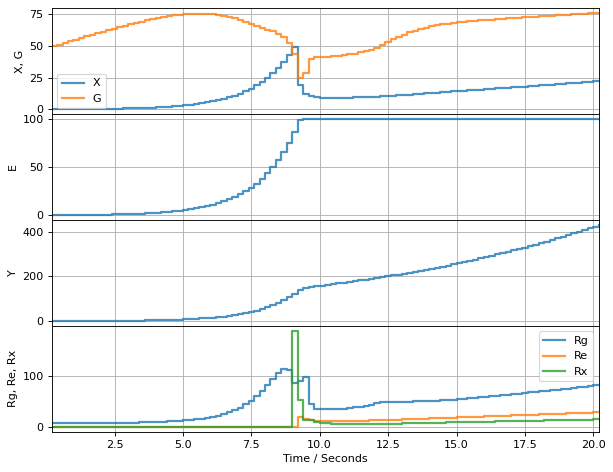

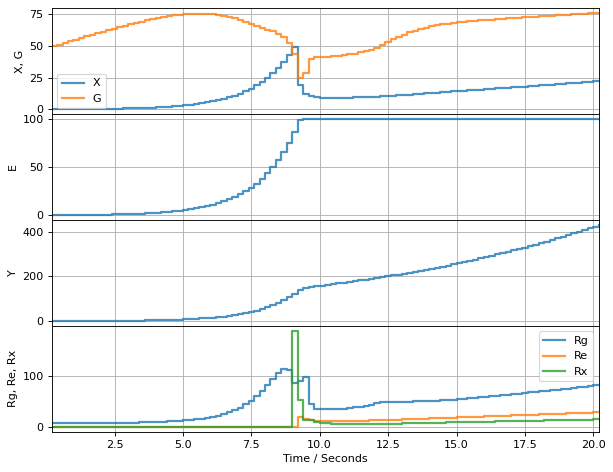

In [145]:
# set up control program
from tclab import Historian, Plotter, clock

# create a controller instance
controller = predictive_control()
Rg, Re, Rx = next(controller)

# create estimator instance
observer = reactor_observer()
X, G, E, Y = next(observer)

# set up historian and plotter

h = Historian([('X', lambda: X), 
                ('G', lambda: G), 
                ('E', lambda: E), 
                ('Y', lambda: Y), 
                ('Rg', lambda: Rg),
                ('Re', lambda: Re),
                ('Rx', lambda: Rx)])

p = Plotter(h, 20, layout=[['X','G'], ['E'], ['Y'], ['Rg','Re','Rx']])

# set up event loop, using While statements to iterate from t=0 t0 t=20
t = 0
while t < 20:
    t = t+0.2
    
    # get PVs from observer
    X, G, E, Y = observer.send([t, Rg, Re, Rx])
    # get MVs from controller
    Rg, Re, Rx = controller.send([X, G, E, Y])
    
    p.update(t)